In [90]:
# This module asks Yahoo for the stock data instead of downloading an outdated CSV from Kaggle
import yfinance as yf
# This module helps train the model that is going to predict the price
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import pandas as pd

In [91]:
# This variable is calling the yf module to get the data based on the stock symbol
stock = yf.Ticker("CDNS") # Using the Cadence Design Systems sotck as an example
stock = stock.history(period="max")
stock.to_csv("stockPrice.csv")

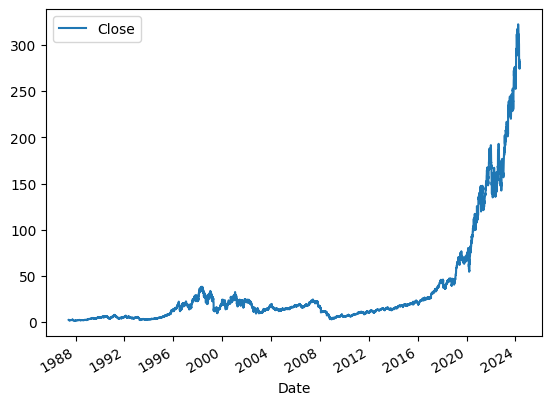

In [92]:
# Plotting
stock.plot.line(y="Close", use_index=True)
del stock["Dividends"]
del stock["Stock Splits"]

In [93]:
# Prediction backbone
stock["Tomorrow"] = stock["Close"].shift(-1)

In [94]:
stock["Target"] = (stock["Tomorrow"] > stock["Close"]).astype(int)
stock = stock.loc["1990-01-01":].copy()

In [95]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)
train = stock.iloc[:-100]
test = stock.iloc[-100:]
predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [96]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.6666666666666666

<Axes: xlabel='Date'>

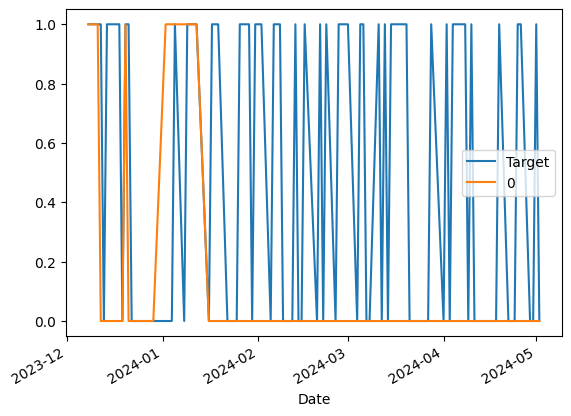

In [97]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [98]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [99]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [100]:
predictions = backtest(stock, model, predictors)
predictions["Predictions"].value_counts()
precision_score(predictions["Target"], predictions["Predictions"])
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.512195
0    0.487805
Name: count, dtype: float64

In [101]:
horizons = [2,5,60,250,1000]
new_predictors = []
for horizon in horizons:
    rolling_averages = stock.rolling(horizon).mean()
    ration_column = f"Close_Ration_{horizon}"
    stock[ration_column] = stock["Close"] / rolling_averages["Close"]
    trend_column = f"Trend_{horizon}"
    stock[trend_column] = stock.shift(1).rolling(horizon).sum()["Target"]
    new_predictors += [ration_column, trend_column]

stock = stock.dropna(subset=stock.columns[stock.columns != "Tomorrow"])


In [102]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [103]:
predictions = backtest(stock, model, new_predictors)
predictions["Predictions"].value_counts()

Predictions
0    2968
1    2182
Name: count, dtype: int64

In [104]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5238313473877176